In [1]:
import re
import urllib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [9]:
url = 'https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=6cd8d424-dfaa-4bdd-9410-a3d656e1176e&limit=50000'  
fileobj = json.loads(urllib.request.urlopen(url).read())['result']

df = pd.DataFrame(fileobj['records'])
df['Most Recent Date'] = pd.to_datetime(df['Most Recent Date'])
df.index = df['Most Recent Date']
df.index.name = 'Date'

sbdf = df.query("`County Name` == 'Santa Barbara'").sort_index()
name_map = {
    'COVID-19 Positive Patients': 'Hospitalized (Confirmed)',
    'ICU COVID-19 Positive Patients': 'ICU (Confirmed)',
    'Suspected COVID-19 Positive Patients': 'Hospitalized (Suspected)',
    'ICU COVID-19 Suspected Patients': 'ICU (Suspected)'
}
sbdf.rename(columns=name_map, inplace=True)

sbc = sbdf.copy()
sbc['Hospitalized (Confirmed)'] -= sbc['ICU (Confirmed)']
sbc['Hospitalized (Suspected)'] -= sbc['ICU (Suspected)']
sbc['Date'] = sbc.index

cm = plt.get_cmap('tab20')

def mpl_to_plotly(cmap):
    colors = ((np.array(c) * 255).astype('int') for c in cm.colors)
    pl_colorscale = [f'rgb{tuple(color)}' for color in colors]
    return pl_colorscale

pxtab20 = mpl_to_plotly(cm)

Hospitalized (Confirmed)    0
ICU (Confirmed)             0
Hospitalized (Suspected)    1
ICU (Suspected)             0
dtype: int64

See the [interactive version](hospitalized_sb.html).

In [4]:
cm = plt.get_cmap('tab20')

def mpl_to_plotly(cmap):
    colors = ((np.array(c) * 255).astype('int') for c in cm.colors)
    pl_colorscale = [f'rgb{tuple(color)}' for color in colors]
    return pl_colorscale

pxtab20 = mpl_to_plotly(cm)

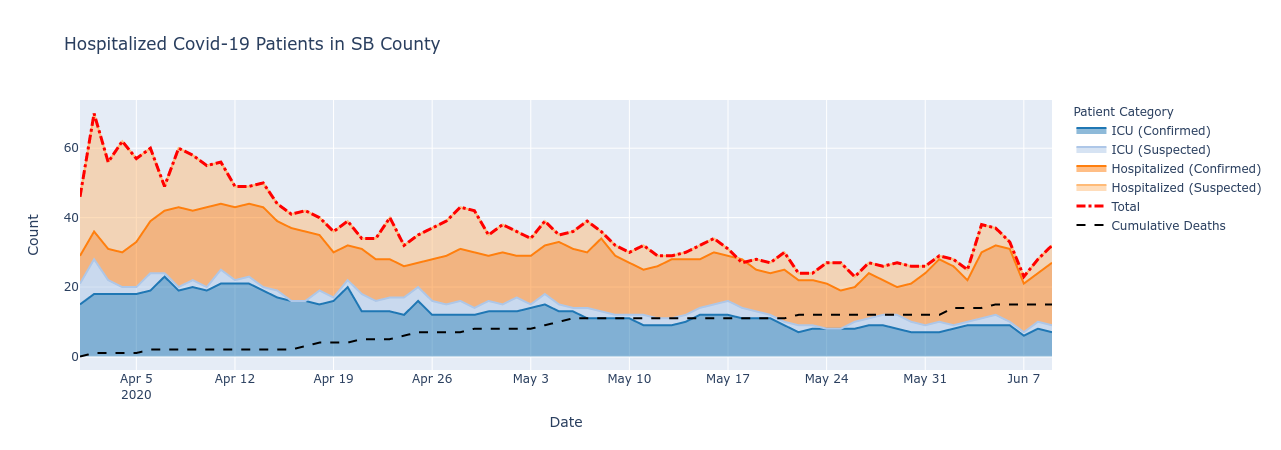

In [17]:
sbcm = sbc.melt(value_vars=name_map.values(), id_vars='Date', var_name='Patient Category', value_name='Count')
pc_order = {
    'ICU (Confirmed)': '1',
    'ICU (Suspected)': '2',
    'Hospitalized (Confirmed)': '3',
    'Hospitalized (Suspected)': '4'
}
sbcm = pd.concat([sbcm.query("`Patient Category`==@cat") for cat in pc_order.keys()])
fig = px.area(sbcm, x='Date', y='Count', color='Patient Category',
              title="Hospitalized Covid-19 Patients in SB County", color_discrete_sequence=pxtab20)
tot = sbcm.groupby('Date').sum()
fig.add_trace(go.Scatter(x=tot.index, y=tot.Count, mode='lines', name='Total', line=dict(dash='dashdot', width=3, color='red')))
fig.add_trace(go.Scatter(x=sbdf.index, y=sbdf['Total Count Deaths'], mode='lines', name='Cumulative Deaths', 
                         line=dict(dash='dash', width=2, color='black')))
fig.show()
import plotly.io as pio
pio.write_html(fig, file='hospitalized_sb.html')

In [114]:
sbcm.columns

Index(['Date', 'Hospitalized Patient Category', 'Count'], dtype='object')

In [8]:
death_per_confirmed = (sbdf['Total Count Deaths'].max() / sbdf['Total Count Confirmed'].max()) * 100
n_dead = sbdf['Total Count Deaths'].max().astype('int')
print(f"{n_dead} total deaths. {death_per_confirmed:.2f}% case fatality rate as of {sbdf.index.max().strftime('%B %-d, %Y')}.")

15 total deaths. 0.81% case fatality rate as of June 9, 2020.


## Scrape

Get the county level data from [here](https://publichealthsbc.org/status-reports/).

In [9]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

url = 'https://publichealthsbc.org/status-reports/'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

page = urlopen(req).read()
soup = BeautifulSoup(page, 'html.parser')

status_containers = soup.findAll('div', class_='elementor-accordion-item')

def getDate(stat_con):
    date_text = stat_con.find('div', class_='elementor-tab-title').text.replace('\n', '').replace('as of ', '')
    return pd.to_datetime(str(date_text))

def getTable(stat_con):
    try:
        tab = stat_con.find('td', text='Active Cases').findParents('table')[0]
    except AttributeError:
        tab = None
    return tab

def getDataframe(stat_con):
    date = getDate(stat_con)
    tab_html = getTable(stat_con)
    df = pd.read_html(str(tab_html), header=0, index_col=0)[0]
    df = df.apply(lambda s: s.replace('—', '0')).apply(pd.to_numeric)
    df['Date'] = date
    df['Category'] = df.index.to_series()
    df.set_index('Date', inplace=True, drop=False)
    return df

def communityDF(stat_con_list):
    df_list = []
    for stat_con in stat_con_list:
        tab = getTable(stat_con)
        if tab:
            df_list.append(getDataframe(stat_con))
    return pd.concat(df_list).pivot(index='Date', columns='Category', values='Community')
        
tables = [getTable(sc) for sc in status_containers]
dfs = [getDataframe(sc) for sc in status_containers[:2]]

def shorten(s):
    pat = re.compile('([A-Z\s]+($|\s))')
    fa = pat.findall(s)
    s = fa[0][0].title() if fa else ''
    return s

def getGeogDF(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
        df['Date'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
    return df

def getDailyCases(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    df_list = []
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
        df['date_label'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
        keep_these = ['Date', 'Daily Cases', 'Geographic Area']
        df_list.append(df[keep_these])
    df = pd.concat(df_list)
    df = pd.pivot(df, index='Date', columns='Geographic Area', values='Daily Cases')
    return df

def getTotalConfirmed(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    df_list = []
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
#         df['Date'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
        keep_these = ['Date', 'Total Confirmed Cases', 'Geographic Area']
        df_list.append(df[keep_these])
    df = pd.concat(df_list)
    df = pd.pivot(df, index='Date', columns='Geographic Area', values='Total Confirmed Cases')
    return df

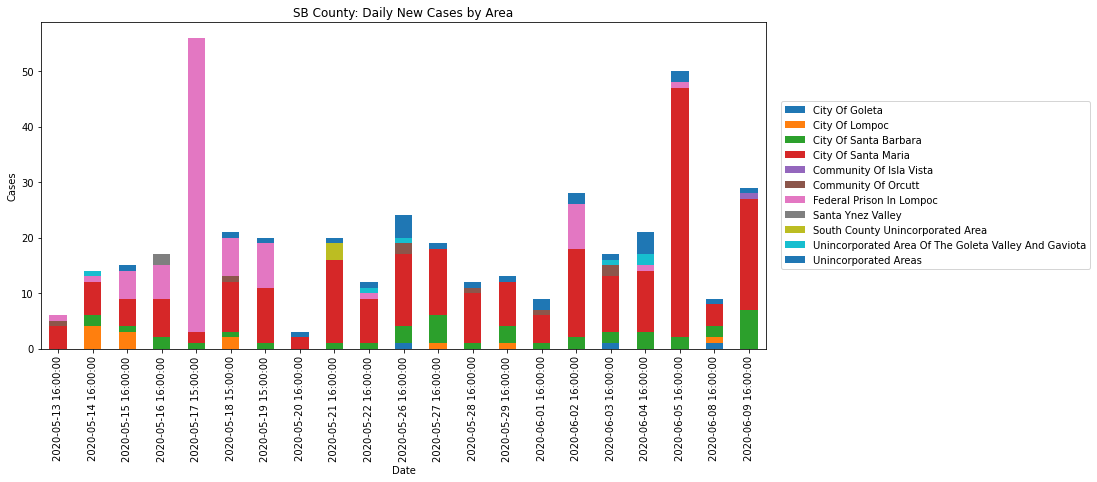

In [10]:
dcdf = getDailyCases(soup).astype('float')
ax = dcdf.plot.bar(stacked=True, figsize=(13, 6), title='SB County: Daily New Cases by Area')
foo = ax.set_ylabel('Cases')
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

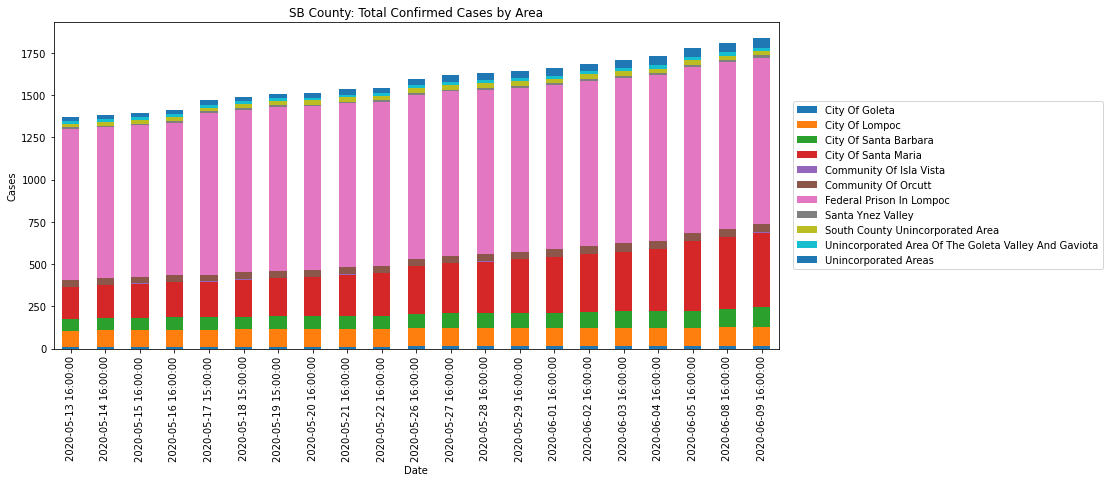

In [11]:
tcdf = getTotalConfirmed(soup).astype('float')
ax = tcdf.plot.bar(stacked=True, figsize=(13, 6), title='SB County: Total Confirmed Cases by Area')
foo = ax.set_ylabel('Cases')
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

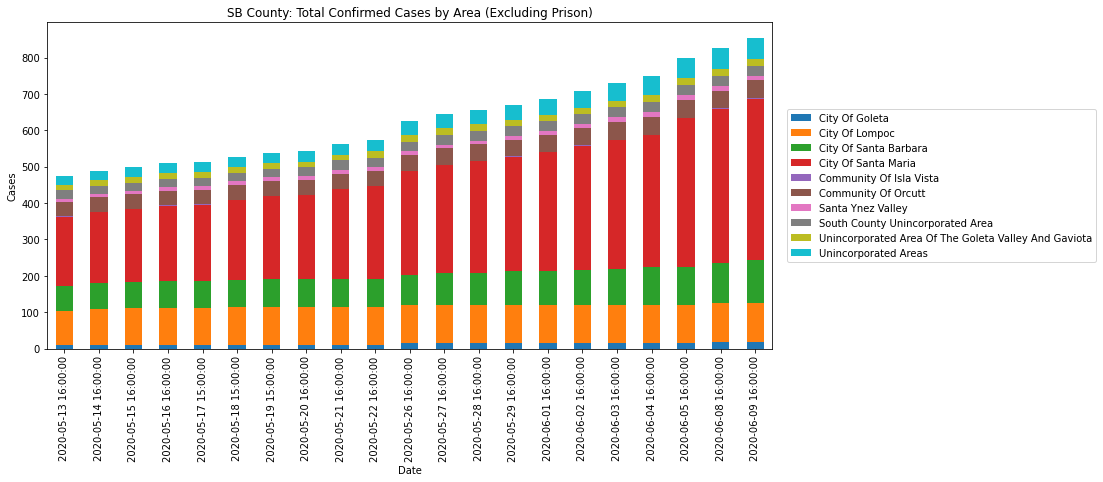

In [12]:
ax = tcdf.drop("Federal Prison In Lompoc", axis=1).plot.bar(stacked=True, figsize=(13, 6), title='SB County: Total Confirmed Cases by Area (Excluding Prison)')
foo = ax.set_ylabel('Cases')
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

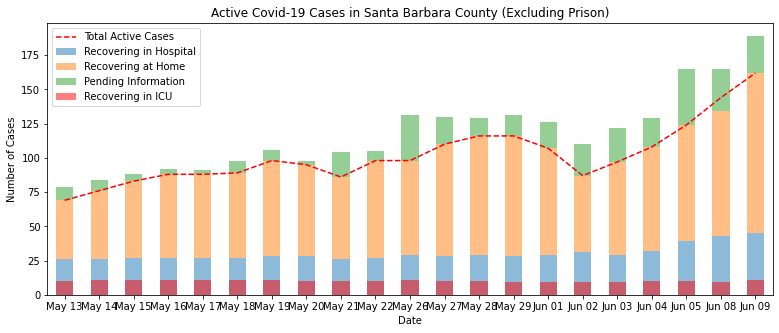

In [13]:
cdf = communityDF(status_containers)
cdf.index = cdf.index.to_series().apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
active_cols = [ 'Recovering in Hospital', 'Recovering at Home', 'Pending Information']
ax = cdf[active_cols].plot.bar(figsize=(13,5), stacked=True, alpha=0.5)
ax = cdf['Recovering in ICU'].plot.bar(alpha=0.5, ax=ax, legend='Recovering in ICU', color='r', title='Active Covid-19 Cases in Santa Barbara County (Excluding Prison)')
ax = cdf['Active Cases'].plot(ax=ax, color='red', linestyle='--', label='Total Active Cases')
# ax = cdf['Active Cases'].diff().plot(ax=ax, color='b', label='Change')
foo = ax.set_ylabel('Number of Cases')
foo = plt.legend(loc="upper left")

In [14]:
cdf

Category,Active Cases,Deaths,Pending Information,Recovered Cases,Recovering at Home,Recovering in Hospital,Recovering in ICU
Date,,,,,,,
May 13,69.0,9.0,10.0,394.0,43.0,26.0,10.0
May 14,76.0,NaN,8.0,401.0,50.0,26.0,11.0
May 15,83.0,NaN,5.0,407.0,56.0,27.0,11.0
May 16,88.0,NaN,4.0,414.0,61.0,27.0,11.0
May 17,88.0,NaN,3.0,418.0,61.0,27.0,11.0
May 18,89.0,NaN,9.0,426.0,62.0,27.0,11.0
May 19,98.0,NaN,8.0,432.0,70.0,28.0,11.0
May 20,95.0,NaN,3.0,443.0,67.0,28.0,10.0
May 21,86.0,NaN,18.0,457.0,60.0,26.0,10.0


In [16]:
!jupyter nbconvert SB_Covid.ipynb --to html --no-input --output index.html

[NbConvertApp] Converting notebook SB_Covid.ipynb to html
[NbConvertApp] Writing 4017363 bytes to index.html
